In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
import numpy as np
import glob
mpl.style.use('seaborn-talk')
import ROOT

Welcome to JupyROOT 6.16/00


In [2]:
%%cpp -d

#include "sPhenixStyle.C"
#include "SaveCanvas.C"
#include <TStyle.h>

In [3]:
%%cpp

SetsPhenixStyle();
gStyle->SetOptStat(0);
gStyle->SetOptFit(1111);
TVirtualFitter::SetDefaultFitter("Minuit2");

gSystem->Load("libg4eval.so");

sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


In [42]:
base_dir = 'production-3-full-beam-full-magnet'
CautiousLabel = f'Internal preview only\ntag {base_dir}'
# base_dir = 'Scraper at z 350 cm'


detector_map = {
    'MAPS Vertex' : ['MVTX'],
    'TPC Tracker' : ['SVTX'],
    'e-going GEM' : ['EGEM_0', 'EGEM_1', 'EGEM_2', 'EGEM_3'],
    'h-going GEM' : ['FGEM_2', 'FGEM_3', 'FGEM_4'],
    'Forward Silicon' : ['FST_0', 'FST_1','FST_2','FST_3','FST_4']
}

In [5]:
df_facets= pd.read_csv(os.path.join(base_dir, 'Facet_CheckAll.csv'))
df_facets.set_index('Facet', inplace=True)
df_facets

,Flux,Phi
Facet,,
18964.0,2.700000e+15,0.423537
18965.0,6.220000e+15,0.257193
18966.0,5.280000e+15,0.059895
18967.0,5.280000e+15,-0.059974
18968.0,6.210000e+15,-0.257590
18982.0,1.620000e+15,-2.709813
18983.0,3.340000e+15,-2.897719
18984.0,2.320000e+16,-3.085536
18985.0,2.320000e+16,3.085618


In [7]:
# facet = int(18966)

for facet_f in df_facets.index.to_list():
    facet = int(facet_f)
    filenames = glob.glob(os.path.join(base_dir, f'{facet}.[0-9]*.csv_SynRadAna.root'))
#     print(len(filenames))

    src_filenames=" ".join(filenames);
    joint_file = os.path.join(base_dir, f'{facet}_SUM.csv_SynRadAna.root')

    if (not os.path.exists(joint_file)):
        print(os.popen(f'hadd -f {joint_file} {src_filenames} ').read())
    else:
        print(os.popen(f'ls -lhv {joint_file} ').read())

-rw-r--r-- 1 jinhuang rhphenix 97K May 28 09:21 production-3-full-beam-full-magnet/18964_SUM.csv_SynRadAna.root

-rw-r--r-- 1 jinhuang rhphenix 98K May 28 09:21 production-3-full-beam-full-magnet/18965_SUM.csv_SynRadAna.root

-rw-r--r-- 1 jinhuang rhphenix 200K May 28 00:20 production-3-full-beam-full-magnet/18966_SUM.csv_SynRadAna.root

-rw-r--r-- 1 jinhuang rhphenix 199K May 28 09:21 production-3-full-beam-full-magnet/18967_SUM.csv_SynRadAna.root

-rw-r--r-- 1 jinhuang rhphenix 98K May 28 09:21 production-3-full-beam-full-magnet/18968_SUM.csv_SynRadAna.root

-rw-r--r-- 1 jinhuang rhphenix 95K May 28 09:21 production-3-full-beam-full-magnet/18982_SUM.csv_SynRadAna.root

-rw-r--r-- 1 jinhuang rhphenix 97K May 28 09:21 production-3-full-beam-full-magnet/18983_SUM.csv_SynRadAna.root

-rw-r--r-- 1 jinhuang rhphenix 161K May 28 09:21 production-3-full-beam-full-magnet/18984_SUM.csv_SynRadAna.root

-rw-r--r-- 1 jinhuang rhphenix 161K May 28 09:21 production-3-full-beam-full-magnet/18985_SUM

In [23]:
dict_rate = {'Facet' : [], 'Flux' : [],'Phi' : [],'Flux_Normalization_Scale' : []}


print(detector_map)

for name, entries in detector_map.items():
    dict_rate[name] = []
    for entry in entries:
        dict_rate[entry] = []

print(dict_rate)


for facet_f in df_facets.index.to_list():
    facet = int(facet_f)
    
    joint_file = os.path.join(base_dir, f'{facet}_SUM.csv_SynRadAna.root')
    facet_flux_noarmlized = df_facets.loc[facet,'Flux']
    facet_phi_ave = df_facets.loc[facet,'Phi']
    
    root_file = ROOT.TFile.Open(joint_file)
    h_SynRadAna_Normalization = root_file.Get('h_SynRadAna_Normalization')
    facet_flux_noarmlization_scale = facet_flux_noarmlized / h_SynRadAna_Normalization.GetBinContent(3);
    print(f'Facet {facet} scale = {facet_flux_noarmlization_scale:.2e} @ phi = {facet_phi_ave:.2f}')
    
    dict_rate['Facet'].append(facet)
    dict_rate['Flux'].append(facet_flux_noarmlized)
    dict_rate['Phi'].append(facet_phi_ave)
    dict_rate['Flux_Normalization_Scale'].append(facet_flux_noarmlization_scale)
    
    for detector_group, entries in detector_map.items():
        group_rate = 0
        
        for detector in entries:
            
            h_SynRadAna_nHit = root_file.Get(f'h_SynRadAna_{detector}_nHit')
            h_SynRadAna_nHit = root_file.Get(f'h_SynRadAna_{detector}_nHit')
            h_SynRadAna_nHit_flux = h_SynRadAna_nHit.ProjectionX(f'h_SynRadAna_{detector}_nHit_flux',1,1)
            h_SynRadAna_nHit_flux.Scale(facet_flux_noarmlization_scale);
            # Rate sum hit
#             Rate = h_SynRadAna_nHit_flux.GetMean()*h_SynRadAna_nHit_flux.GetSum()
            #rate sum photons
            Rate = h_SynRadAna_nHit_flux.Integral(2,-1)
        
            group_rate = group_rate + Rate

            dict_rate[detector].append(Rate)
            
        dict_rate[detector_group].append(group_rate)

{'MAPS Vertex': ['MVTX'], 'TPC Tracker': ['SVTX'], 'e-going GEM': ['EGEM_0', 'EGEM_1', 'EGEM_2', 'EGEM_3'], 'h-going GEM': ['FGEM_2', 'FGEM_3', 'FGEM_4'], 'Forward Silicon': ['FST_0', 'FST_1', 'FST_2', 'FST_3', 'FST_4']}
{'Facet': [], 'Flux': [], 'Phi': [], 'Flux_Normalization_Scale': [], 'MAPS Vertex': [], 'MVTX': [], 'TPC Tracker': [], 'SVTX': [], 'e-going GEM': [], 'EGEM_0': [], 'EGEM_1': [], 'EGEM_2': [], 'EGEM_3': [], 'h-going GEM': [], 'FGEM_2': [], 'FGEM_3': [], 'FGEM_4': [], 'Forward Silicon': [], 'FST_0': [], 'FST_1': [], 'FST_2': [], 'FST_3': [], 'FST_4': []}
Facet 18964 scale = 9.06e-05 @ phi = 0.42
Facet 18965 scale = 2.09e-04 @ phi = 0.26
Facet 18966 scale = 2.62e-04 @ phi = 0.06
Facet 18967 scale = 2.63e-04 @ phi = -0.06
Facet 18968 scale = 2.10e-04 @ phi = -0.26
Facet 18982 scale = 5.42e-05 @ phi = -2.71
Facet 18983 scale = 1.13e-04 @ phi = -2.90
Facet 18984 scale = 8.59e-04 @ phi = -3.09
Facet 18985 scale = 8.60e-04 @ phi = 3.09
Facet 18986 scale = 1.13e-04 @ phi = 2.90

In [27]:
df_rate = pd.DataFrame(dict_rate)
df_rate.set_index('Phi', inplace=True)

df_rate

,Facet,Flux,Flux_Normalization_Scale,MAPS Vertex,MVTX,TPC Tracker,SVTX,e-going GEM,EGEM_0,EGEM_1,...,h-going GEM,FGEM_2,FGEM_3,FGEM_4,Forward Silicon,FST_0,FST_1,FST_2,FST_3,FST_4
Phi,,,,,,,,,,,,,,,,,,,,,
0.423537,18964,2.700000e+15,0.000091,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
0.257193,18965,6.220000e+15,0.000209,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
0.059895,18966,5.280000e+15,0.000262,3.035432e+11,3.035432e+11,8.662845e+11,8.662845e+11,1.259887e+10,6.286365e+09,6.312500e+09,...,0.0,0.0,0.0,0.0,1.927675e+10,1.253598e+10,6.740771e+09,0.0,0.0,0.0
-0.059974,18967,5.280000e+15,0.000263,3.714318e+11,3.714318e+11,9.309735e+11,9.309735e+11,1.252967e+10,0.000000e+00,1.252967e+10,...,0.0,0.0,0.0,0.0,2.998083e+10,1.650700e+10,1.347383e+10,0.0,0.0,0.0
-0.257590,18968,6.210000e+15,0.000210,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
-2.709813,18982,1.620000e+15,0.000054,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
-2.897719,18983,3.340000e+15,0.000113,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,6.114857e+09,0.000000e+00,6.114857e+09,0.0,0.0,0.0
-3.085536,18984,2.320000e+16,0.000859,2.706430e+11,2.706430e+11,1.052308e+12,1.052308e+12,3.036710e+10,2.036056e+10,1.000654e+10,...,0.0,0.0,0.0,0.0,7.777801e+10,1.086412e+10,6.691389e+10,0.0,0.0,0.0
3.085618,18985,2.320000e+16,0.000860,4.036002e+11,4.036002e+11,1.102902e+12,1.102902e+12,9.785938e+09,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,1.713285e+11,1.085387e+10,1.604747e+11,0.0,0.0,0.0


11

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

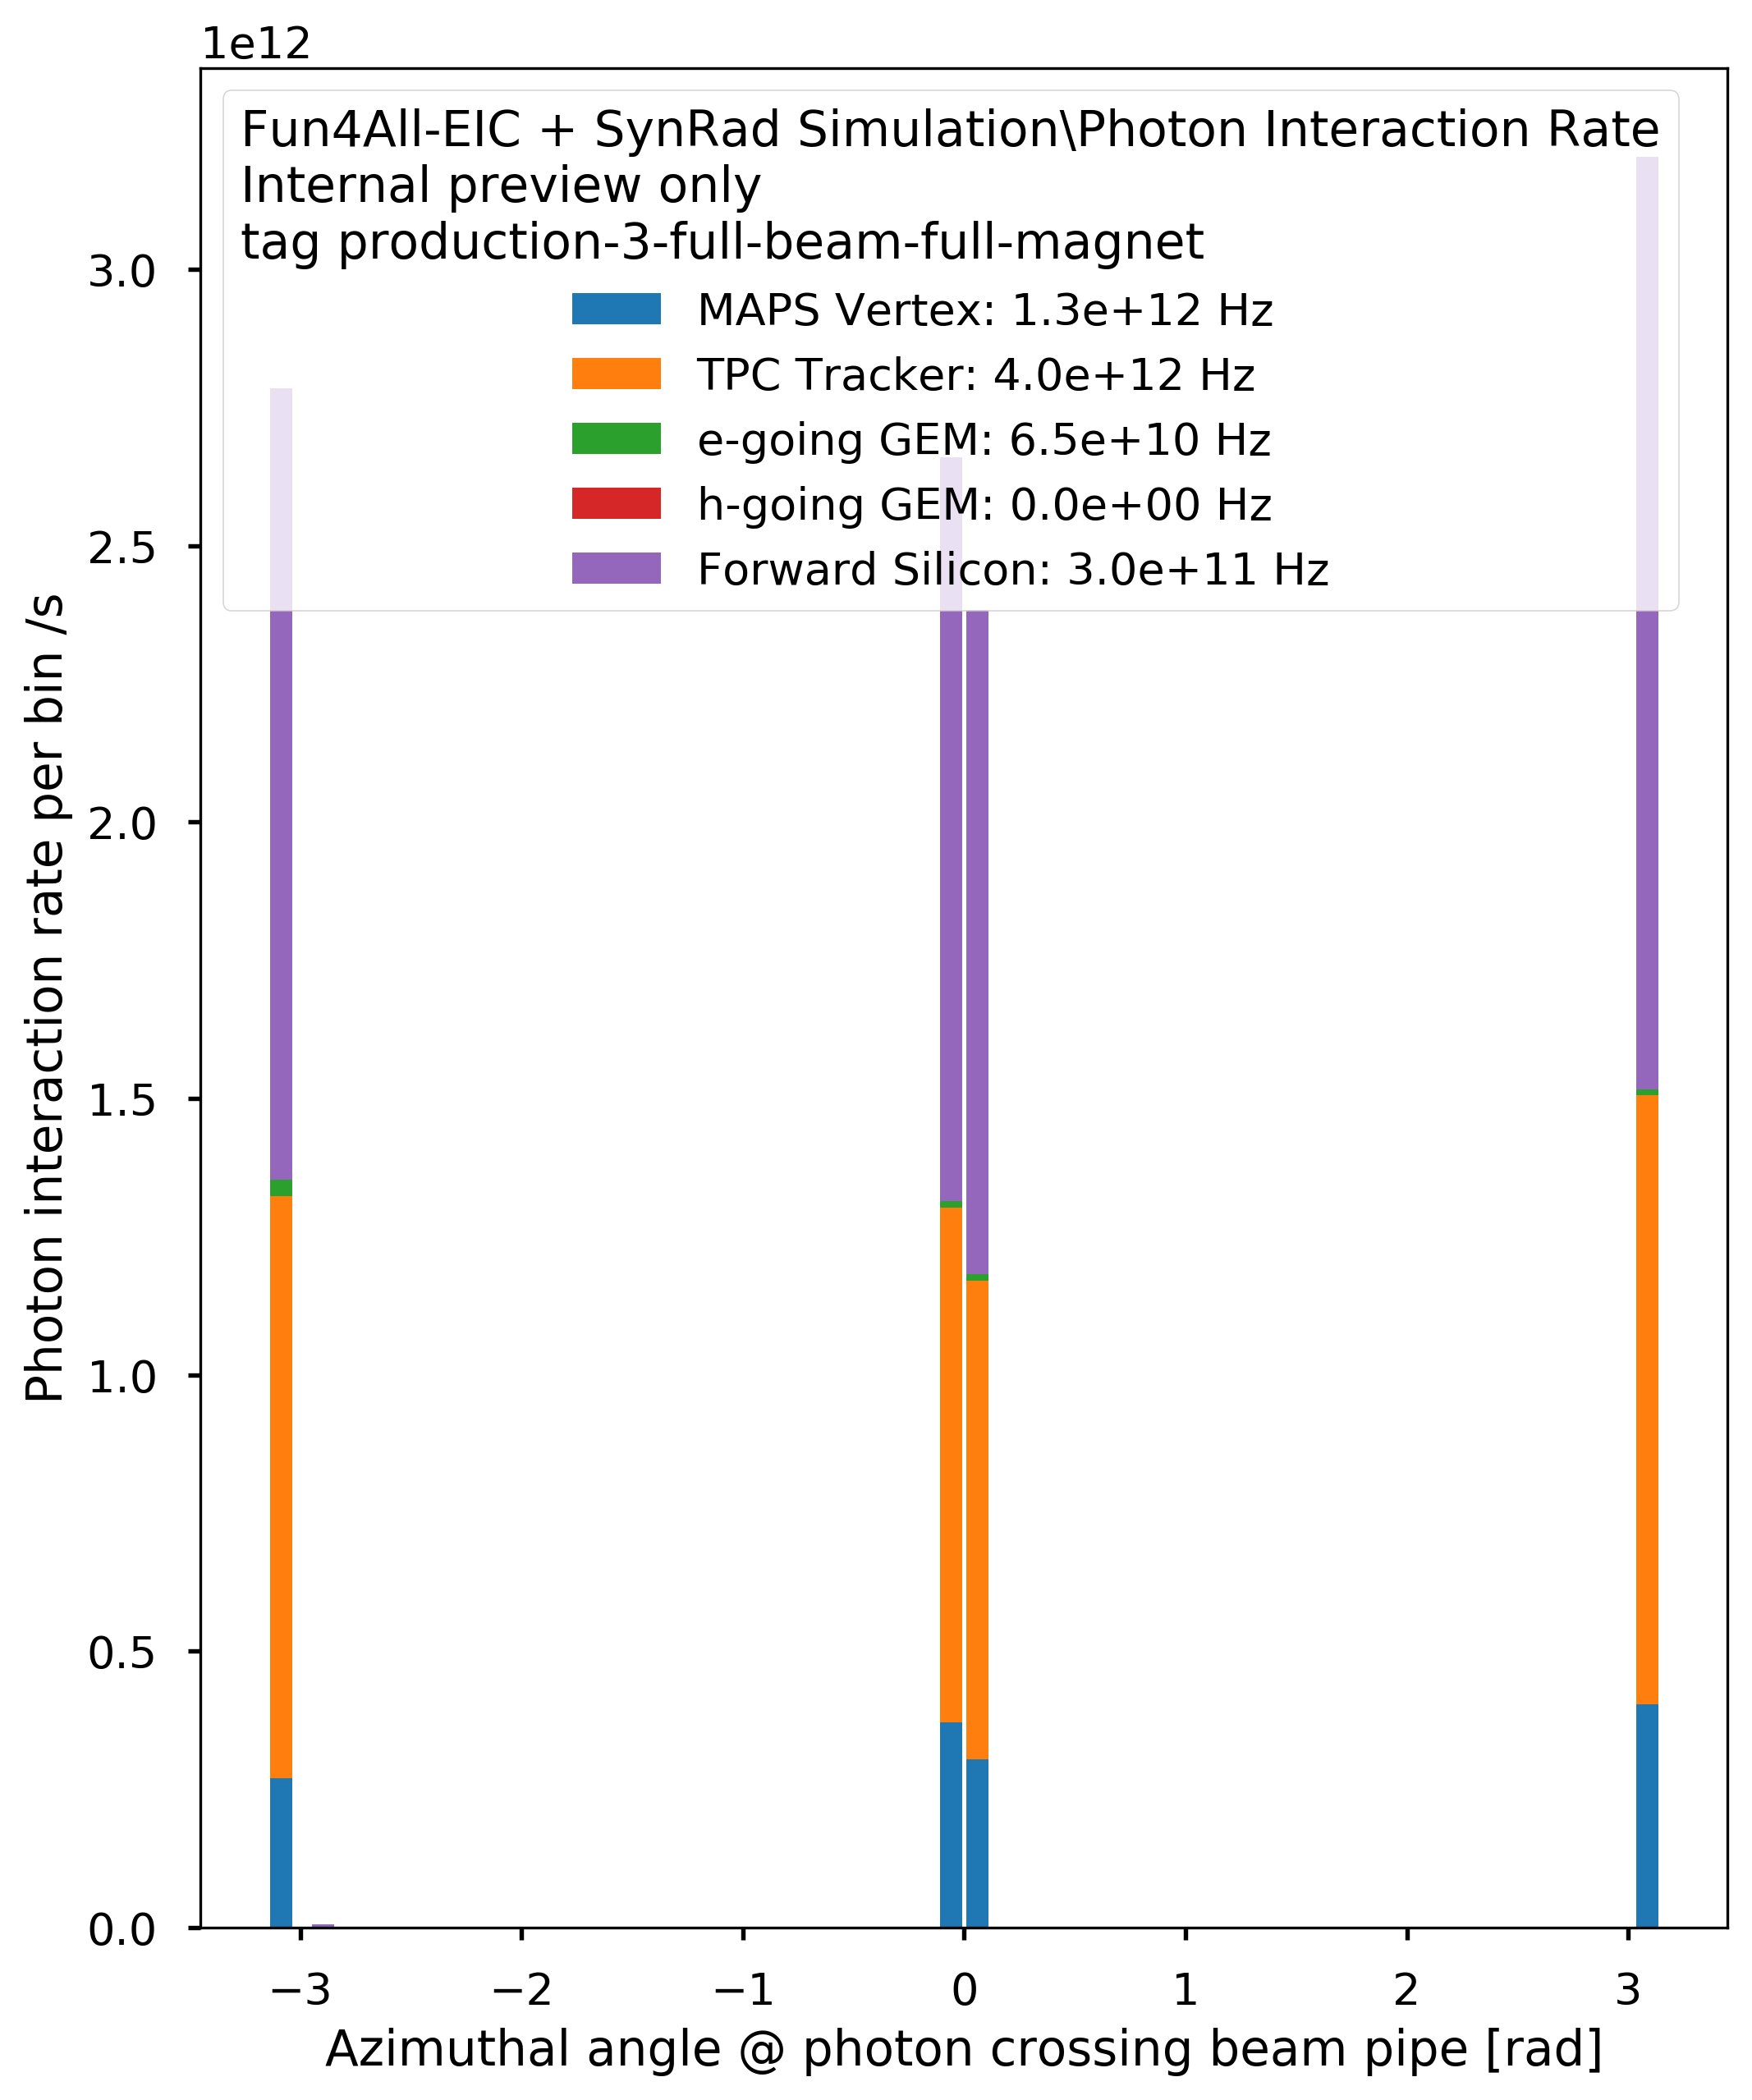

In [68]:
width = 0.1

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 10), dpi=300)
ax=axs


baserate = baserate = np.zeros(df_rate['Facet'].count())

for detector_group, entries in detector_map.items():
    rates = df_rate[detector_group].to_numpy()
    
    stagged_rate = rates + baserate;
    
    ax.bar(
        df_rate.index.to_numpy(), 
        stagged_rate,  width , 
         bottom= baserate,
        label = f'{detector_group}: {np.sum(rates):.1e} Hz');
    
    baserate = stagged_rate

ax.set_xlabel("Azimuthal angle @ photon crossing beam pipe [rad]");
ax.set_ylabel("Photon interaction rate per bin /s");
ax.legend(loc='upper left',
         title = f'Fun4All-EIC + SynRad Simulation\nPhoton Interaction Rate\n{CautiousLabel}',
         title_fontsize='x-large'
         )
# chartBox = ax.get_position()
# ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
#          title = f'Fun4All-EIC + SynRad Simulation\n{CautiousLabel}',
#          title_fontsize='x-large'
#          )


plt.savefig(os.path.join(base_dir, 'Photon Interaction Rate.png'), bbox_inches='tight')
plt.savefig(os.path.join(base_dir, 'Photon Interaction Rate.pdf'), bbox_inches='tight')

In [37]:
axs

In [65]:
facet = 18966

joint_file = os.path.join(base_dir, f'{facet}_SUM.csv_SynRadAna.root')
facet_flux_noarmlized = df_facets.loc[facet,'Flux']
facet_phi_ave = df_facets.loc[facet,'Phi']

root_file = ROOT.TFile.Open(joint_file)
h_SynRadAna_Normalization = root_file.Get('h_SynRadAna_Normalization')
facet_flux_noarmlization_scale = facet_flux_noarmlized / h_SynRadAna_Normalization.GetBinContent(3);
print(f'Facet {facet} scale = {facet_flux_noarmlization_scale:.2e} @ phi = {facet_phi_ave:.2f}')

Facet 18966 scale = 2.62e-04 @ phi = 0.06


In [66]:
detector_group = 'MAPS Vertex'
detector = 'MVTX'
h_SynRadAna_nHit = root_file.Get(f'h_SynRadAna_{detector}_nHit')
h_SynRadAna_nHit_flux = h_SynRadAna_nHit.ProjectionX(f'h_SynRadAna_{detector}_nHit_flux',1,1)
h_SynRadAna_nHit_flux.Scale(facet_flux_noarmlization_scale);

print( h_SynRadAna_nHit_flux.GetMean()*h_SynRadAna_nHit_flux.GetSum())
print( f'{h_SynRadAna_nHit_flux.Integral(2,-1):.3e}')

588029669472.0774
3.035e+11


In [19]:
print( f'{h_SynRadAna_nHit_flux.GetBinContent(1):.3e}')

5.280e+15


Save TH1 h_SynRadAna_Normalization
Save TH1 h_SynRadAna_photonEnergy_flux
Save TH1 h_SynRadAna_MVTXHit_nHit_flux
Save TH1 h_SynRadAna_MVTX_nHit_flux
removed ‘production-3-full-beam-full-magnet/18966_SUM.csv_SynRadAna.root_Check.svg’


Warning in <TCanvas::Constructor>: Deleting canvas with same name: Check
Info in <TCanvas::Print>: png file production-3-full-beam-full-magnet/18966_SUM.csv_SynRadAna.root_Check.png has been created
Info in <TCanvas::SaveAs>: ROOT file production-3-full-beam-full-magnet/18966_SUM.csv_SynRadAna.root_Check.root has been created
Info in <TCanvas::Print>: eps file production-3-full-beam-full-magnet/18966_SUM.csv_SynRadAna.root_Check.eps has been created
Info in <TCanvas::Print>: SVG file production-3-full-beam-full-magnet/18966_SUM.csv_SynRadAna.root_Check.svg has been created
Info in <TCanvas::SaveSource>: C++ Macro file: production-3-full-beam-full-magnet/18966_SUM.csv_SynRadAna.root_Check.C has been generated


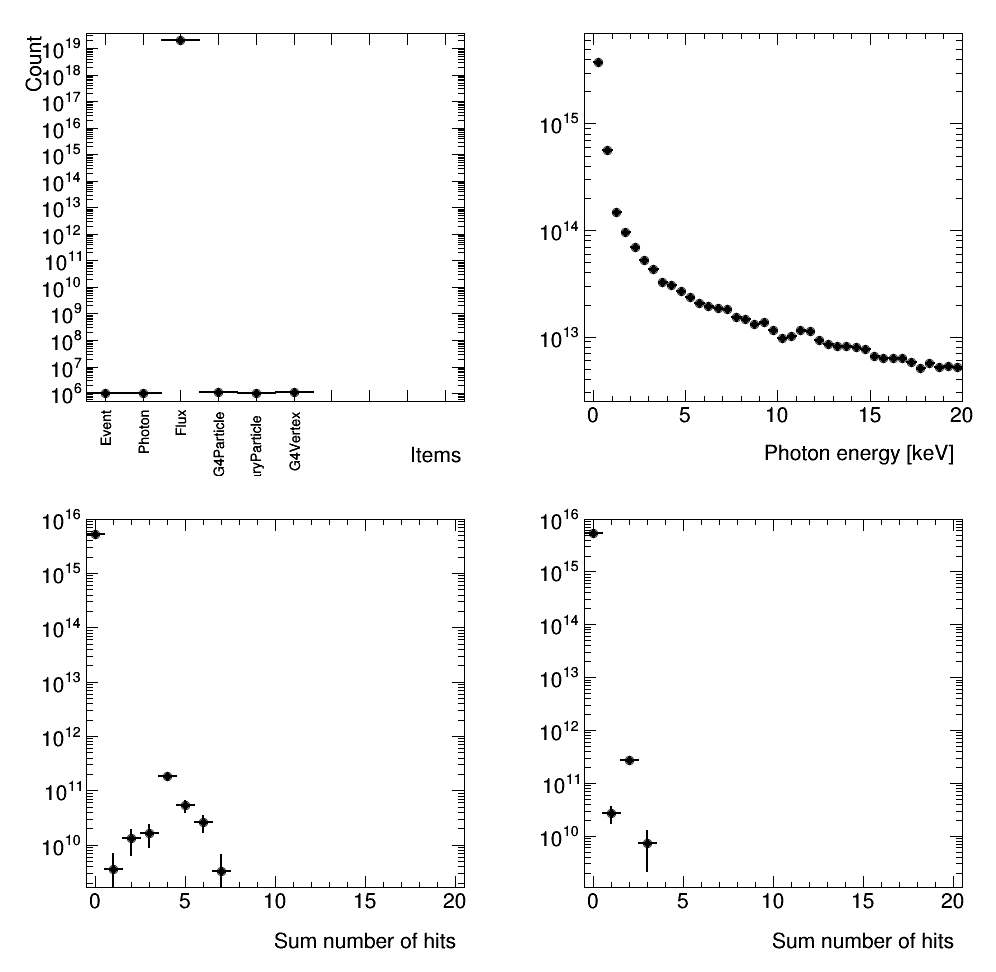

In [67]:
c1 = ROOT.TCanvas( 'Check', 'Check', 1000, 1000)
c1.Divide(2, 2);
idx = 1;

p = c1.cd(idx);
idx = idx + 1;
c1.Update();
p.SetLogy();

h_SynRadAna_Normalization.Draw();


p = c1.cd(idx);
idx = idx + 1;
c1.Update();
p.SetLogy();

h_SynRadAna_photonEnergy = root_file.Get('h_SynRadAna_photonEnergy')
h_SynRadAna_photonEnergy_flux = h_SynRadAna_photonEnergy.ProjectionX('h_SynRadAna_photonEnergy_flux',1,1)
h_SynRadAna_photonEnergy_flux.Scale(facet_flux_noarmlization_scale);
h_SynRadAna_photonEnergy_flux.Rebin(10)
h_SynRadAna_photonEnergy_flux.GetXaxis().SetRangeUser(-.5,20);
h_SynRadAna_photonEnergy_flux.Draw();


p = c1.cd(idx);
idx = idx + 1;
c1.Update();
p.SetLogy();

h_SynRadAna_MVTXHit_nHit = root_file.Get('h_SynRadAna_MVTXHit_nHit')
h_SynRadAna_MVTXHit_nHit_flux = h_SynRadAna_MVTXHit_nHit.ProjectionX('h_SynRadAna_MVTXHit_nHit_flux',1,1)
h_SynRadAna_MVTXHit_nHit_flux.Scale(facet_flux_noarmlization_scale);
h_SynRadAna_MVTXHit_nHit_flux.GetXaxis().SetRangeUser(-.5,20);
h_SynRadAna_MVTXHit_nHit_flux.Draw();


p = c1.cd(idx);
idx = idx + 1;
c1.Update();
p.SetLogy();

h_SynRadAna_MVTX_nHit = root_file.Get('h_SynRadAna_MVTX_nHit')
h_SynRadAna_MVTX_nHit_flux = h_SynRadAna_MVTX_nHit.ProjectionX('h_SynRadAna_MVTX_nHit_flux',1,1)
h_SynRadAna_MVTX_nHit_flux.Scale(facet_flux_noarmlization_scale);
h_SynRadAna_MVTX_nHit_flux.GetXaxis().SetRangeUser(-.5,20);
h_SynRadAna_MVTX_nHit_flux.Draw();

c1.Draw()


ROOT.SaveCanvas(c1,f'{joint_file}_Check', True);

In [14]:
h_SynRadAna_MVTX_nHit_flux.GetMean()*h_SynRadAna_MVTX_nHit_flux.GetSum()

588029669472.0305

In [15]:
root_file.ls()

TFile**		production-3-full-beam-full-magnet/18966_SUM.csv_SynRadAna.root	
 TFile*		production-3-full-beam-full-magnet/18966_SUM.csv_SynRadAna.root	
  OBJ: TH2D	h_SynRadAna_MVTX_nHit	Hit sum : 0 at: 0x7028130
  OBJ: TH2D	h_SynRadAna_photonEnergy	Source photon : 0 at: 0x731c7a0
  OBJ: TH2D	h_SynRadAna_MVTXHit_nHit	Hit sum : 0 at: 0x72143d0
  OBJ: TH1D	h_SynRadAna_Normalization	h_SynRadAna_ Normalization : 0 at: 0x7117ff0
  OBJ: TH1D	h_SynRadAna_photonEnergy_flux	Source photon : 0 at: 0x72995a0
  OBJ: TH1D	h_SynRadAna_MVTXHit_nHit_flux	Hit sum : 0 at: 0x6ff2490
  OBJ: TH1D	h_SynRadAna_MVTX_nHit_flux	Hit sum : 0 at: 0x71f6fa0
  KEY: TH2D	h_SynRadAna_BH_1_nHit;1	Hit sum
  KEY: TH2D	h_SynRadAna_BH_1_photonEnergy;1	Hit source photon
  KEY: TH2D	h_SynRadAna_BH_1_sumEdep;1	Hit sum energy distribution
  KEY: TH2D	h_SynRadAna_BH_FORWARD_NEG_nHit;1	Hit sum
  KEY: TH2D	h_SynRadAna_BH_FORWARD_NEG_photonEnergy;1	Hit source photon
  KEY: TH2D	h_SynRadAna_BH_FORWARD_NEG_sumEdep;1	Hit sum energy distrib

In [16]:
# from time import sleep
# from IPython.display import display, Javascript
# import hashlib

# def save_notebook(file_path):
#     start_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
#     display(Javascript('IPython.notebook.save_checkpoint();'))
#     current_md5 = start_md5

#     while start_md5 == current_md5:
#         sleep(1)
#         current_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
        
#     print(f'saved to {file_path} {start_md5} -> {current_md5}');


# save_notebook('CheckAll.ipynb')
os.system('jupyter nbconvert --to html RateCalculation.ipynb')
print(os.popen(f'mv -fv RateCalculation.html \'{base_dir}/\'').read())


‘RateCalculation.html’ -> ‘production-3-full-beam-full-magnet/RateCalculation.html’



[NbConvertApp] Converting notebook RateCalculation.ipynb to html
[NbConvertApp] Writing 374130 bytes to RateCalculation.html
